# CONSTELLATION TX (Modulation)

**1. Choisir M**

In [6]:
import numpy as np
M = 16  # Exemple pour 16-QAM
k = int(np.log2(M))  # Nombre de bits par symbole

**2. Créer la grille IQ**

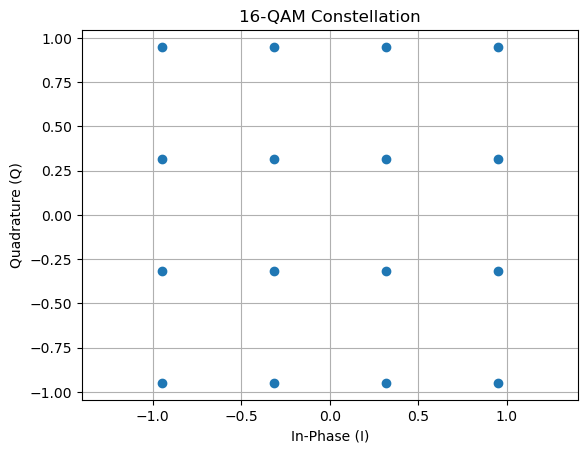

In [10]:
import numpy as np

def generate_qam_constellation(M, normalize=True):
    
    # √M doit être un entier (constellation carrée)
    m_sqrt = int(np.sqrt(M))
    if m_sqrt ** 2 != M:
        raise ValueError("M doit être un carré parfait (ex: 4, 16, 64, ...)")
    
    # Créer les niveaux I et Q
    levels = np.arange(-(m_sqrt - 1), m_sqrt + 1, 2)
    
    # Créer la grille : produit cartésien entre I et Q
    I, Q = np.meshgrid(levels, levels)
    iq_points = I.flatten() + 1j * Q.flatten()  # Signal complexe = I + jQ
    
    if normalize:
        # Normaliser pour que l'énergie moyenne soit 1
        avg_energy = np.mean(np.abs(iq_points) ** 2)
        iq_points /= np.sqrt(avg_energy)
    
    return iq_points
import matplotlib.pyplot as plt

points = generate_qam_constellation(M)

plt.scatter(points.real, points.imag)
plt.grid(True)
plt.title(f"{M}-QAM Constellation")
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.axis("equal")
plt.show()


**3. Mapping : Associer symboles aux coordonnées IQ**

In [19]:
import numpy as np

def int_to_gray(n):
    return n ^ (n >> 1)

def bin_str(n, k):
    return format(n, f'0{k}b')

def generate_qam_mapping(M, start_position='center', use_gray=True):
# code Gray : Le code Gray garantit que 2 symboles voisins n'ont qu’un seul bit différent → plus robuste au bruit.
#top/bottom left : Pour tester l’impact du mapping sur les performances (et faire des graphes SNR/BER).
    k = int(np.log2(M))
    m_sqrt = int(np.sqrt(M))
    if m_sqrt ** 2 != M:
        raise ValueError("M doit être un carré parfait (ex: 4, 16, 64...)")
    
    # Niveaux I/Q (centrés autour de 0)
    levels = np.arange(-(m_sqrt - 1), m_sqrt + 1, 2)

    # Modifier l’ordre selon la position de départ
    if start_position in ['top-left', 'top-right']:
        I = levels[::-1]
    else:
        I = levels
    if start_position in ['top-left', 'bottom-left']:
        Q = levels[::-1]
    else:
        Q = levels

    # Créer la grille IQ
    ii, qq = np.meshgrid(I, Q)
    iq_points = ii.flatten() + 1j * qq.flatten()

    # Normaliser l’énergie à 1
    iq_points /= np.sqrt(np.mean(np.abs(iq_points)**2))

    # Créer le dictionnaire de mapping
    mapping = {}
    for i, point in enumerate(iq_points):
        index = int_to_gray(i) if use_gray else i
        bits = bin_str(index, k)
        mapping[bits] = point

    return mapping
mapping = generate_qam_mapping(M, start_position='top-left', use_gray=True)

# Affichage des correspondances
for bits, point in mapping.items():
    print(f"{bits} → I={point.real:.2f}, Q={point.imag:.2f}")


0000 → I=0.95, Q=0.95
0001 → I=0.32, Q=0.95
0011 → I=-0.32, Q=0.95
0010 → I=-0.95, Q=0.95
0110 → I=0.95, Q=0.32
0111 → I=0.32, Q=0.32
0101 → I=-0.32, Q=0.32
0100 → I=-0.95, Q=0.32
1100 → I=0.95, Q=-0.32
1101 → I=0.32, Q=-0.32
1111 → I=-0.32, Q=-0.32
1110 → I=-0.95, Q=-0.32
1010 → I=0.95, Q=-0.95
1011 → I=0.32, Q=-0.95
1001 → I=-0.32, Q=-0.95
1000 → I=-0.95, Q=-0.95


**4. Visualisation de la constellation TX**

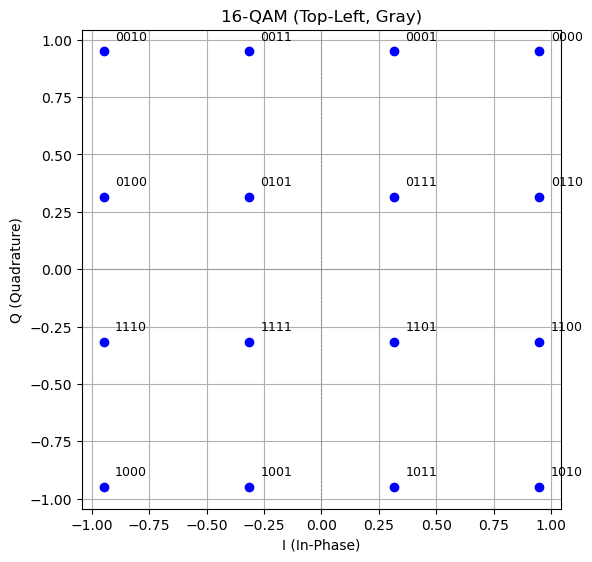

In [21]:
import matplotlib.pyplot as plt

def plot_constellation(mapping, title="Constellation TX"):
    
    plt.figure(figsize=(6, 6))
    for bits, point in mapping.items():
        plt.plot(point.real, point.imag, 'bo')  # point bleu
        plt.text(point.real + 0.05, point.imag + 0.05, bits, fontsize=9)  # label bits

    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.grid(True)
    plt.title(title)
    plt.xlabel("I (In-Phase)")
    plt.ylabel("Q (Quadrature)")
    plt.gca().set_aspect('equal')  # carré
    plt.tight_layout()
    plt.show()
mapping = generate_qam_mapping(M, start_position='top-left', use_gray=True)
plot_constellation(mapping, title="16-QAM (Top-Left, Gray)")


# CONSTELLATION RX (Démodulation)

**1. Ajouter bruit AWGN (bruit blanc)**

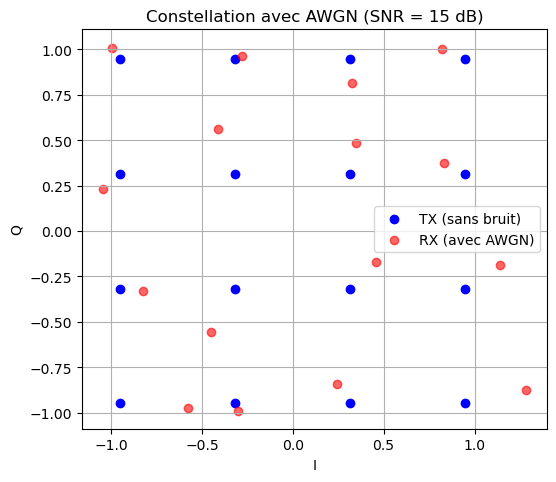

In [24]:
import numpy as np

def add_awgn_noise(signal, snr_dB):
    """
    Ajoute un bruit AWGN (bruit blanc Gaussien) à un signal complexe.

    Retour :
        signal_bruité : ndarray — signal après ajout du bruit
    """
    # Puissance du signal
    signal_power = np.mean(np.abs(signal)**2)

    # Calcul du bruit à partir du SNR
    snr_linear = 10**(snr_dB / 10)
    noise_power = signal_power / snr_linear

    # Génération du bruit complexe (I et Q bruités)
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))

    return signal + noise

bits_list = list(mapping.keys())
tx_symbols = np.array([mapping[b] for b in bits_list])  # tous les symboles de la constellation

# Ajouter bruit AWGN avec un SNR de 15 dB
rx_symbols = add_awgn_noise(tx_symbols, snr_dB=15)

# Visualisation : TX vs RX
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(tx_symbols.real, tx_symbols.imag, color='blue', label='TX (sans bruit)')
plt.scatter(rx_symbols.real, rx_symbols.imag, color='red', alpha=0.6, label='RX (avec AWGN)')
plt.title("Constellation avec AWGN (SNR = 15 dB)")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()


# Ajouter bruit de phase pour tester la robustesse du modem !
Dans la vraie vie, les transmissions ne sont jamais parfaites.

Sans bruit de phase	: Test "idéal" 

Avec bruit de phase : Test réaliste

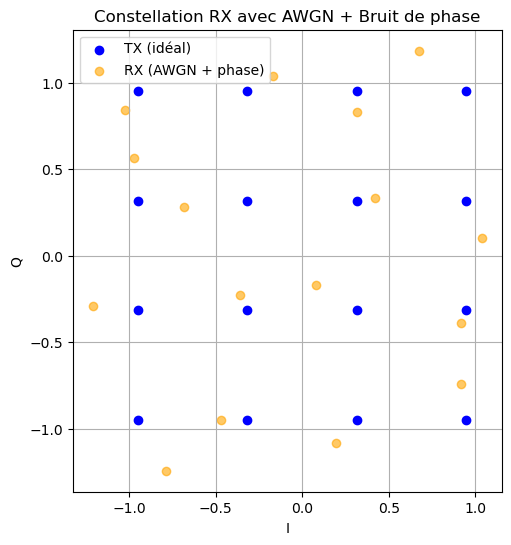

In [28]:
def add_phase_noise(signal, phase_std_deg):
    """
    Ajoute un bruit de phase (rotation aléatoire) à chaque symbole.

    Retour :
        signal_bruité
    """
    # Convertir l'écart-type en radians
    phase_std_rad = np.deg2rad(phase_std_deg)

    # Générer des angles aléatoires selon une loi normale
    phase_noise = np.random.normal(loc=0, scale=phase_std_rad, size=signal.shape)

    # Appliquer la rotation complexe : exp(j * bruit)
    return signal * np.exp(1j * phase_noise)
# TX avec AWGN + bruit de phase
snr = 15
phase_std_deg = 10  # ex : 10° d'écart-type

rx_awgn = add_awgn_noise(tx_symbols, snr)
rx_full = add_phase_noise(rx_awgn, phase_std_deg)

# Affichage
plt.figure(figsize=(6,6))
plt.scatter(tx_symbols.real, tx_symbols.imag, color='blue', label='TX (idéal)')
plt.scatter(rx_full.real, rx_full.imag, color='orange', alpha=0.6, label='RX (AWGN + phase)')
plt.title("Constellation RX avec AWGN + Bruit de phase")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

In [32]:
def demodulate(rx_symbols, mapping):
 
    # Liste des points de référence et leurs bits
    ref_points = np.array(list(mapping.values()))
    ref_bits = list(mapping.keys())

    bits_rx = []

    for sym in rx_symbols:
        distances = np.abs(ref_points - sym)  # distances euclidiennes
        idx_min = np.argmin(distances)        # index du plus proche
        bits_rx.append(ref_bits[idx_min])     # bits correspondants

    return bits_rx
bits_rx = demodulate(rx_symbols, mapping)

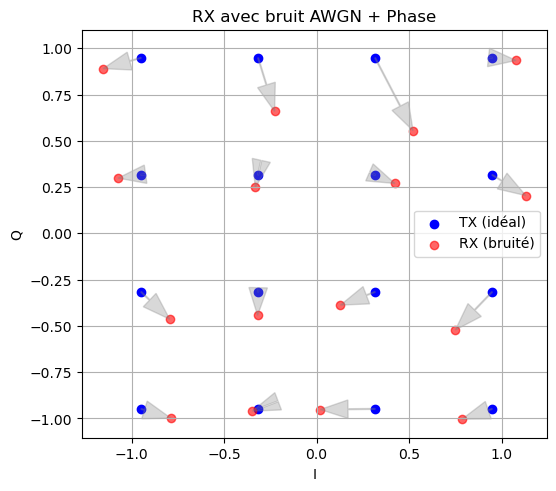

In [34]:
def plot_rx_constellation(rx_symbols, tx_symbols, title="Constellation RX"):
    """
    Affiche les symboles RX bruités et leur écart par rapport aux symboles TX idéaux.
    """
    plt.figure(figsize=(6,6))
    plt.scatter(tx_symbols.real, tx_symbols.imag, color='blue', label='TX (idéal)')
    plt.scatter(rx_symbols.real, rx_symbols.imag, color='red', alpha=0.6, label='RX (bruité)')

    # Dessiner des flèches entre TX ↔ RX pour montrer les erreurs
    for tx, rx in zip(tx_symbols, rx_symbols):
        plt.arrow(tx.real, tx.imag, rx.real - tx.real, rx.imag - tx.imag,
                  color='gray', alpha=0.3, width=0.005, head_width=0.1, length_includes_head=True)

    plt.title(title)
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.grid(True)
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.show()
# 1. Générer mapping TX
mapping = generate_qam_mapping(16, start_position='top-left', use_gray=True)
tx_symbols = np.array([mapping[b] for b in mapping])

# 2. Simuler transmission avec bruit (AWGN + phase optionnelle)
rx_awgn = add_awgn_noise(tx_symbols, snr_dB=15)
rx = add_phase_noise(rx_awgn, phase_std_deg=10)  # ou juste rx = rx_awgn

# 3. Démoduler les symboles bruités
bits_rx = demodulate(rx, mapping)
bits_tx = list(mapping.keys())

# 4. Affichage
plot_rx_constellation(rx, tx_symbols, title="RX avec bruit AWGN + Phase")